## Getting some data

In [1]:
# We'll be downloading this middlebury Stereo Dataset, and storing in ./data
dataurl = "http://vision.middlebury.edu/stereo/submit3/zip/MiddEval3-data-Q.zip"
datadir = "./data"
dataset = "./data/MiddEval3/testQ/Djembe"
downsample = 1

In [2]:
# Download, unzip and read dataset into images

import urllib2
import zipfile
import glob
import os
from skimage import io, transform
import numpy as np

if not os.path.exists(datadir):
    os.makedirs(datadir)

f = open(datadir + '/sweep.zip', 'wb') 
f.write(urllib2.urlopen(dataurl).read())
f.close()

zip_ref = zipfile.ZipFile(datadir + '/sweep.zip', 'r')
zip_ref.extractall(datadir)

# Load images
imagenames = sorted(glob.glob(dataset + "/im?.png"))
images = [io.imread(i).astype(float)/255.0 for i in imagenames]
# Downsample since we're memory limited when running in the cloud
images = [transform.resize(i, (i.shape[0] / downsample, i.shape[1] / downsample)) for i in images ]

# Parse Middlebury calibration file into python dictionary
calibf = open(dataset + '/calib.txt','r')
calib = { l.split('=')[0]: l.split('=')[1] for l in calibf.read().split('\n')[:-1]}
calibf.close()

# Utility to parse middlebury matrix into numpy matrix (taking into account any image scaling)
def LoadK(name, downsample):
    K = np.array([ r.strip().split(' ') for r in calib['cam0'][1:-1].split(';')]).astype(np.float)
    K[0,0] /= downsample
    K[1,1] /= downsample
    K[0:2,2] = 0.5 + (K[0:2,2] + 0.5) / downsample
    return K

# Left and Right camera intrinsic matrices
Kl = LoadK('cam0', downsample=downsample)
Kr = LoadK('cam1', downsample=downsample)
# l_r should be read as 'the optic center of the left image, wrt right images frame of reference'
l_r = np.array([calib['baseline'],'0','0']).astype(np.float) / 1000.0
# These middlebury images are rectified such that there is no rotation
R_rl = np.eye(3)
# The left and right image
I_l = images[0]
I_r = images[1]

ImportError: No module named skimage

## Visualizing the Dataset

In [0]:
# Display Utilities

import numpy as np
from skimage import io
from skimage import transform
from matplotlib import pyplot
from mpl_toolkits import mplot3d

"""
Display a list of images or image filenames in a single figure
Use 'cols' and 'scale' to adjust the layout and view dimensions
"""
def show_images(images, cols = 1, titles = None, scale = 1):
    n_images = len(images)
    rows = int(np.ceil(n_images/float(cols)))
    if titles is None: titles = ['Image (%d)' % i for i in range(0,n_images)]
    if isinstance(titles, str): titles = [titles] * n_images
      
    fig = pyplot.figure()
    pyplot.axis('off')
    # Load any filenames
    images = [ (io.imread(i) if isinstance(i,str) else i) for i in images]
    vmin = np.amin([np.amin(i) for i in images])
    vmax = np.amax([np.amax(i) for i in images])
    
    for n, (image, title) in enumerate(zip(images, titles)):
        # Load any filenames
        a = fig.add_subplot(rows, cols, n+1)
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
        if image.ndim == 2:
            pyplot.gray()
        pyplot.imshow(image, vmin=vmin, vmax=vmax)
        a.set_title(title)
    fig.set_size_inches( scale * np.array(fig.get_size_inches()) * np.array([cols,rows]) )
    pyplot.show()
    
'''
Destructures lists of tuples into tuple of lists. The logical inverse of zip.
'''
def unzip(x):
  return tuple([list(tup) for tup in zip(*x)])

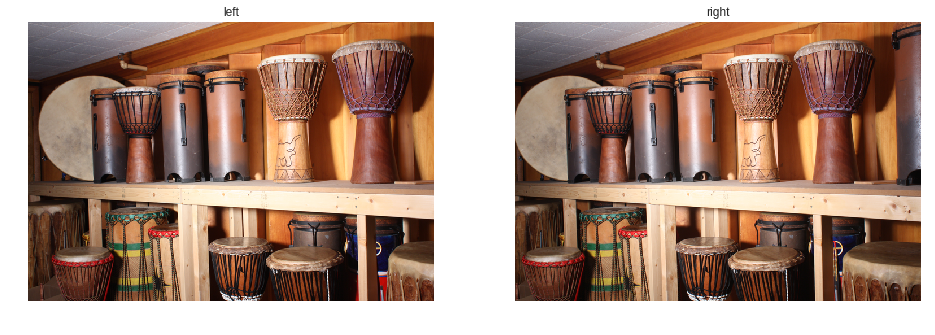

In [4]:
show_images(images, titles=['left', 'right'], cols=2)

# Plane Sweep

In [0]:
disp_search = np.linspace(1.0/16.0, 1.0/2.0, 128)
diffs = np.zeros((I_l.shape[0], I_l.shape[1], len(disp_search)))

# Sweep over image in inverse depth (/disparity)
for d in range(0,len(disp_search)):
    # Depth of plane
    z = 1.0 / disp_search[d]
    # We'll use fronto parallel planes with the following normal:
    n = np.array([0,0,1])
    # Since these images are rectified, H_rl ends up as a trivial translation!
    H_rl = np.matmul(np.matmul(Kr, R_rl - np.outer(l_r, n/z)), np.linalg.inv(Kl))
    # Synthesize an image of I_l from I_r induced by plane n/z
    Iwarp_l = transform.warp(I_r, H_rl)
    # Compare our synthetic image to our observed left image
    diff3 = I_l - Iwarp_l
    diffs[:,:,d] = np.sqrt(diff3[:,:,0]**2 + diff3[:,:,1]**2 + diff3[:,:,2]**2)

In [9]:
# Create an animation to see the plane-sweep

%matplotlib inline
from IPython.display import HTML
import matplotlib.patches as patches
import matplotlib.animation as animation

fig,ax = pyplot.subplots(1)
ax.axis('off')
im = ax.imshow(diffs[:,:,0])
pyplot.close()

def updatefig(frame):
    global diffs
    i = diffs[:,:,frame];
    i = transform.resize(i, (i.shape[0]/4, i.shape[1]/4))
    im.set_array(i)
    return im,
  
HTML(animation.FuncAnimation(fig, updatefig, interval=60, blit=True, frames=range(0,diffs.shape[2],4)).to_jshtml())

## Min Cost Plane

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


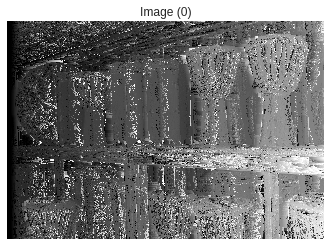

In [7]:
depth = np.argmin(diffs, axis=2)
show_images([depth])

## Agregation

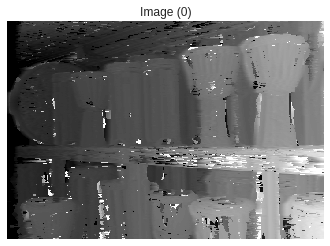

In [8]:
import scipy.linalg as slin
import scipy

# Blurring in the DSI is a very simple aggregation strategy to consider small neighbourhoods
blurred_diffs = [scipy.ndimage.filters.gaussian_filter(diff, 3.0) for diff in diffs]
blurred_depth = np.argmin(blurred_diffs, axis=2)
show_images([blurred_depth])